## HYD 142 Final Project

Team B: Kenneth Larrieu, Catherine Truong, Charles Polc

### a. Plot the data sets, find their histograms, and find the first four moments and coefficient of variation

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

df_az = pd.read_excel('data_project_19.xlsx', sheet_name='PARIA RIVER, AZ')
df_or = pd.read_excel('data_project_19.xlsx', sheet_name='JOHN DAY RIVER, OR')

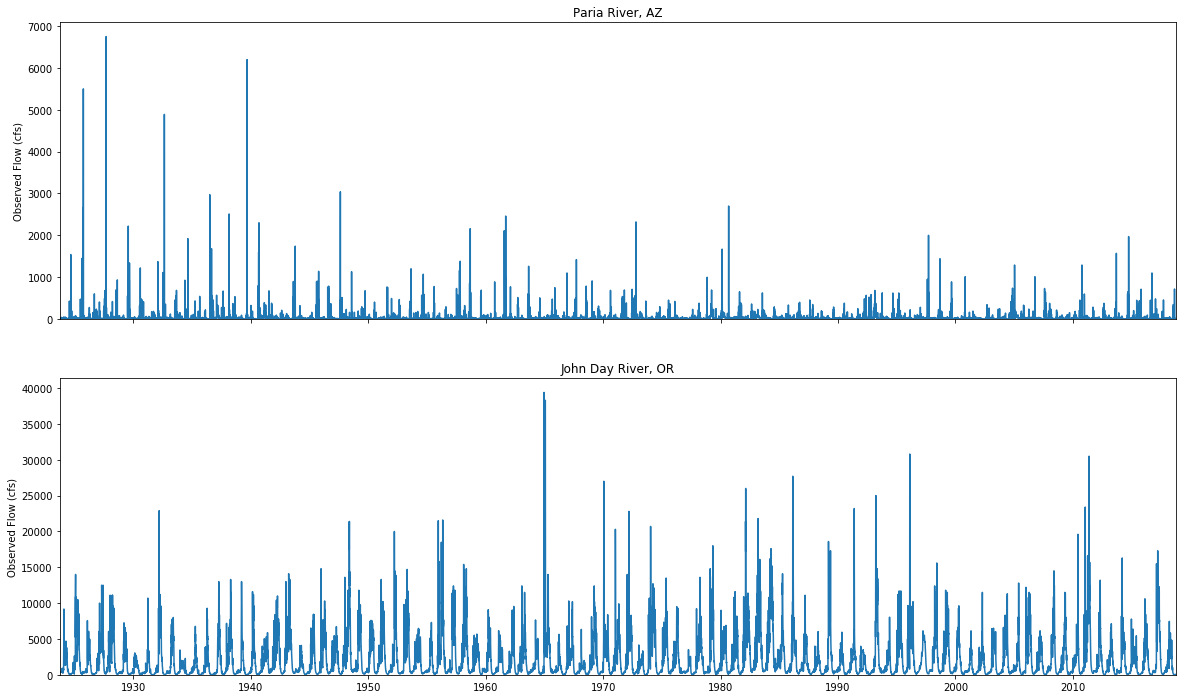

In [14]:
# plot the data sets

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20, 12))
ax[0].plot(df_az.DATE, df_az.Flow)
ax[0].set(title='Paria River, AZ')
ax[1].plot(df_or.DATE, df_or.Flow)
ax[1].set(title='John Day River, OR')
for axis in ax:
    axis.set(xlim=[df_az.DATE.tolist()[0], df_az.DATE.tolist()[-1]], ylabel='Observed Flow (cfs)')
    axis.set_ylim(bottom=0)
plt.show()

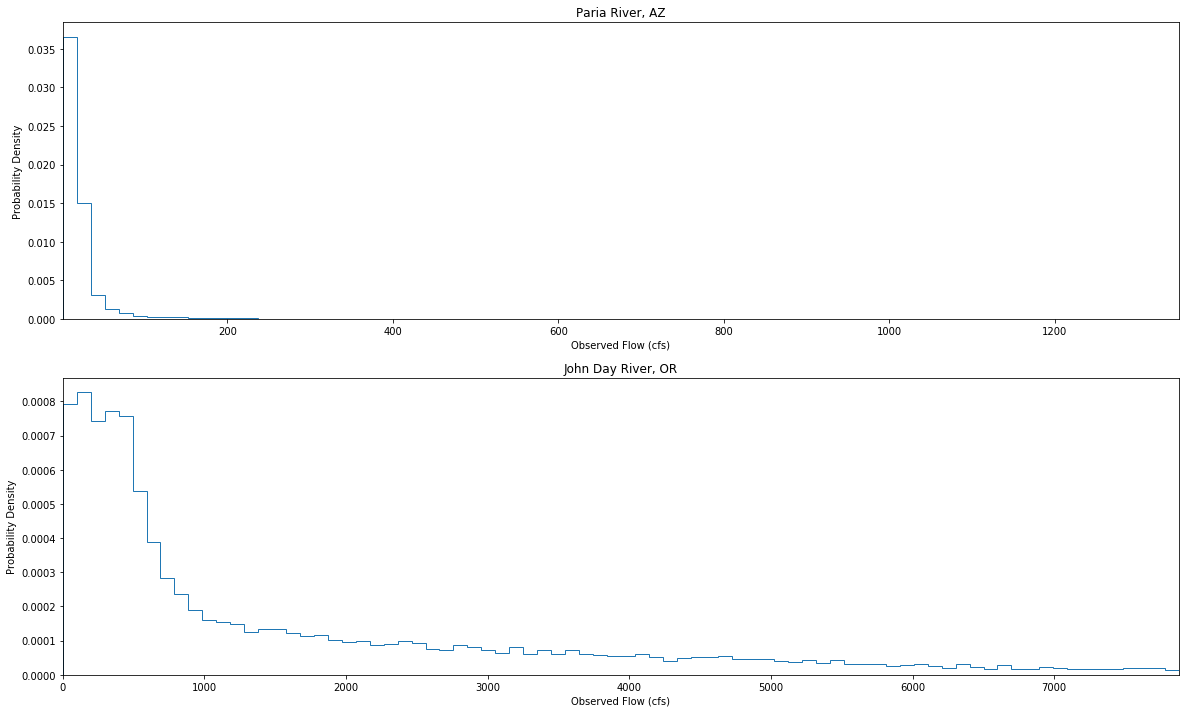

In [62]:
# histograms

fig, ax = plt.subplots(2, 1, figsize=(20, 12))
ax[0].hist(df_az.Flow, density=True, histtype='step', bins=400)
ax[0].set(title='Paria River, AZ',
          xlabel='Observed Flow (cfs)', ylabel='Probability Density',
          xlim=[min(df_az.Flow), 0.2*max(df_az.Flow)])
ax[1].hist(df_or.Flow, density=True, histtype='step', bins=400)
ax[1].set(title='John Day River, OR',
          xlabel='Observed Flow (cfs)', ylabel='Probability Density',
          xlim=[min(df_or.Flow), 0.2*max(df_or.Flow)])
plt.show()

In [63]:
# moments and CV

powers = np.arange(1, 5)
az_moments, or_moments = [[sum([q**p for q in df.Flow])/len(df) for p in powers] for df in [df_az, df_or]]
az_cv, or_cv = [np.std(df.Flow)/np.mean(df.Flow) for df in [df_az, df_or]]

a_df = pd.DataFrame([az_moments+[az_cv], or_moments+[or_cv]],
                    columns=['$$\mathbb{E}[X^%i]$$' % p for p in powers] +['$$CV$$'],
                   index=['Paria River, AZ', 'John Day River, OR'])
a_df

,$$\mathbb{E}[X^1]$$,$$\mathbb{E}[X^2]$$,$$\mathbb{E}[X^3]$$,$$\mathbb{E}[X^4]$$,$$CV$$
"Paria River, AZ",27.981293,1.276292e+04,3.627005e+07,1.707285e+11,3.911651
"John Day River, OR",2021.069110,1.152401e+07,1.077329e+11,1.472558e+15,1.349536


### b. Suggest two plausible models for such histograms, fitting them using the moments. Plot your results and comment on whether one of the models turns out to be better than the other.

Two plausible models would be ***(Exp, LP-III, Power Law?)***

[1, 2]

### c. Find the autocorrelation function of the records, extending your calculations to a lag equal to a tenth of the data length. Plot your results and comment on the relative decays on the data sets. What are the scales of the sets?

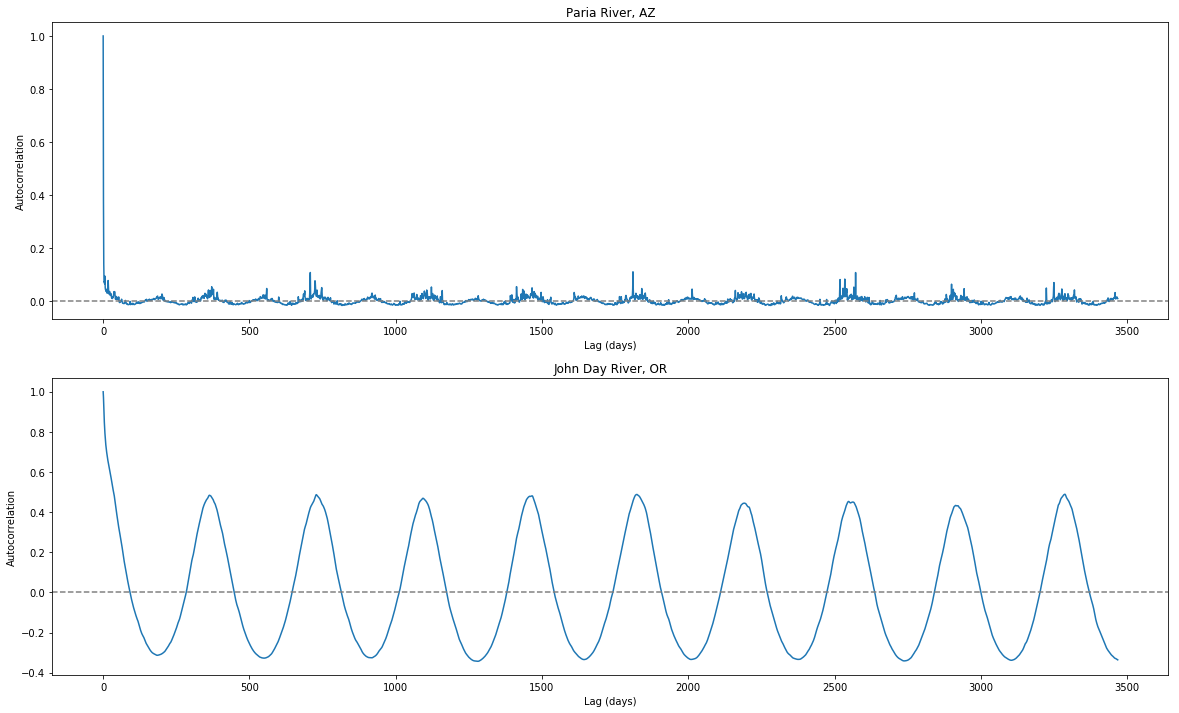

In [84]:
def acf(series, maxlags='default'):
    if maxlags == 'default':
        maxlags = len(series)//10
    lags = np.arange(maxlags)
    acorr = [1] + [np.corrcoef(series[:-lag], series[lag:])[0,1] for lag in lags[1:]]
    return lags, acorr

fig, ax = plt.subplots(2, 1, figsize=(20, 12))
ax[0].plot(*acf(df_az.Flow))
ax[0].set(title='Paria River, AZ')
ax[1].plot(*acf(df_or.Flow))
ax[1].set(title='John Day River, OR')
for axis in ax:
    axis.set(xlabel='Lag (days)', ylabel='Autocorrelation')
    axis.axhline(0, linestyle='--', color='gray')
plt.show()

The John Day River in Oregon decays much more slowly than the Paria River. Both exhibit annual oscillations indicative of periodicity. The John Day River oscillations have much higher amplitudes, indicative of the larger scale/longer memory of the system. This is expected since there is likely more gradual changes in the hydrograph due to a baseflow provided by groundwater and more temperate climate/regular precipitation patterns. In contrast, the Paria River is in an arid setting which exhibits much more flashy, temporally heterogeneous discharge patterns, so there is less correlation.

The scale of the Paria River streamflow is 55 days, while the scale of the John Day River streamflow is 92 days.

### Repeat parts a-c dividing each data set into two sets (the first andthe second halves) in order to test for stationarity, that is, in order to see if results already found are stable.

### Now aggregate daily discharge data sets into monthly discharge data sets.

### g. Plot the new records, find their histograms, and also find the first four moments and coefficient of variation.

### h. Find the autocorrelation function of the new records, extending yourcalculations to a lag equal to a quarter of the data length. Plot yourresults and comment on the trends and relative decays on the two datasets.

### Finally, aggregate all data sets to a yearly scale.

### k. Plot the new records, find their histograms, and also find the first four moments and coefficient of variation.